In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
properties = pd.read_csv('/Users/socrteas/Documents/Kaggle/zillow/data/properties_2016.csv')

/anaconda/envs/zillow/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train = pd.read_csv('/Users/socrteas/Documents/Kaggle/zillow/data/train_2016_v2.csv', parse_dates = ["transactiondate"])
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [4]:
# These will become class attributes
nan_subs = {'airconditioningtypeid': 0, #getdummies
            'architecturalstyletypeid': 0, #getdummies
            'basementsqft': 0,
            'bathroomcnt': 0, 
            'bedroomcnt': 0, 
            'buildingclasstypeid': 0, #get_dummies
            'buildingqualitytypeid': 0, 
            'calculatedbathnbr': 0, 
            'decktypeid': 0, #actually binary
            'finishedfloor1squarefeet': 1348, 
            'calculatedfinishedsquarefeet': 1773,
            'finishedsquarefeet12': 1745, 
            'finishedsquarefeet13': 1404, 
            'finishedsquarefeet15': 2380,
            'finishedsquarefeet50': 1355, 
            'finishedsquarefeet6': 2303, 
            'fips': 0, #getdummies
            'fireplacecnt': 0,
            'fullbathcnt': 0, 
            'garagecarcnt': 0, 
            'garagetotalsqft': 0, 
            'hashottuborspa': False,
            'heatingorsystemtypeid': 0, #getdummies
            'latitude': 0, 
            'longitude': 0, 
            'lat_bins': 0,
            'lon_bins': 0,
            'lotsizesquarefeet': 0, #Lots of heteroscedasticity here, high values have low logerrors
            'poolcnt': 0, 
            'poolsizesum': 0, #Could use 520 (mean) here for rows where poolcnt = 1
            'pooltypeid10': 0, 
            'pooltypeid2': 0, 
            'pooltypeid7': 0,
            'propertycountylandusecode': '0', 
            'propertylandusetypeid': 0,
            'propertyzoningdesc': '0', 
            'rawcensustractandblock': 0, 
            'regionidcity': 0,
            'regionidcounty': 0, #getdummies
            'regionidneighborhood': 0, 
            'regionidzip': 0, 
            'roomcnt': 0,
            'storytypeid': 0, 
            'threequarterbathnbr': 0, 
            'typeconstructiontypeid': 0, #getdummies
            'unitcnt': 1, 
            'yardbuildingsqft17': 0, 
            'yardbuildingsqft26': 0, 
            'yearbuilt': 1968,
            'numberofstories': 1, 
            'fireplaceflag': False, 
            'structuretaxvaluedollarcnt': 180000,  #Lots of heteroscedasticity here, high values have low logerrors
            'taxvaluedollarcnt': 450000,   #Lots of heteroscedasticity here, high values have low logerrors
            'assessmentyear': 2015,
            'landtaxvaluedollarcnt': 280000, #Lots of heteroscedasticity here, high values have low logerrors
            'taxamount': 6000,   #Lots of heteroscedasticity here, high values have low logerrors
            'taxdelinquencyflag': 'N', 
            'taxdelinquencyyear': 16,
            'censustractandblock': '0'
           }

drop_cols = ['propertyzoningdesc', 
             'propertycountylandusecode', 
             'rawcensustractandblock', 
             'regionidcity', #for region variables could substitue mean of previous sales in region
             'regionidneighborhood',
             'regionidzip',
             'censustractandblock',
             'assessmentyear'
# Worried about overfitting with these, but they seem to be performing well             
#              'latitude', 
#              'longitude' 
            ]



drop_indices = ['parcelid', 'logerror','transactiondate']

In [5]:
# Merge the data
# Class method?
merged = pd.merge(train,properties,how='left',on='parcelid')

In [6]:
'''
Data Wrangling Method!!!

Need to:
- Drop useless variables like census tract (at least for now)
- Transform tax DQ year to include century
- Get dummies for relevant fields
- Fix lat/long binning to use same binning on submission data
- Add in time factor slope to account for 1 year to validation timeframe
'''

merged['transaction_month'] = merged['transactiondate'].dt.month

# Bin latitude and longitude to avoid overfit
# Need to create lat_bins and lon_bins as class attributes when the class is created
lat_a, lat_bins = pd.cut(properties.latitude.dropna(), bins=100, labels=False, retbins=True)
lon_a, lon_bins = pd.cut(properties.longitude.dropna(), bins=100, labels=False, retbins=True)

merged['lat_bins'] = pd.cut(merged.latitude, lat_bins, labels=np.arange(100))
merged['lon_bins'] = pd.cut(merged.longitude, lon_bins, labels=np.arange(100))

# Create missing indicators
for key in nan_subs:
    merged[key+'_miss'] = merged[key].isnull()

# Fill NaN's with imputations
merged.fillna(nan_subs, inplace=True)

# Convert ordinal characters to ordinal numeric
taxdelinquencyflag_mapping = {'Y': 1, 'N': 0}
merged.taxdelinquencyflag = merged.taxdelinquencyflag.map(taxdelinquencyflag_mapping)
    
x = merged.drop(drop_cols+drop_indices, axis=1)
y = merged['logerror']

print(x.head())
print(y.head())

   airconditioningtypeid  architecturalstyletypeid  basementsqft  bathroomcnt  \
0                    1.0                       0.0           0.0          2.0   
1                    0.0                       0.0           0.0          3.5   
2                    1.0                       0.0           0.0          3.0   
3                    1.0                       0.0           0.0          2.0   
4                    0.0                       0.0           0.0          2.5   

   bedroomcnt  buildingclasstypeid  buildingqualitytypeid  calculatedbathnbr  \
0         3.0                  0.0                    4.0                2.0   
1         4.0                  0.0                    0.0                3.5   
2         2.0                  0.0                    4.0                3.0   
3         2.0                  0.0                    4.0                2.0   
4         4.0                  0.0                    0.0                2.5   

   decktypeid  finishedfloor1squ

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=8675309)

In [16]:
# Grid searching
param_grid = {'learning_rate': [0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [50, 100],
              'subsample': [0.5],
              'max_features': [0.5, 0.3, 0.1]
             }

est = GradientBoostingRegressor(loss='lad', n_estimators=900, random_state=90210)
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# Fit model using best hyperparameter setting
params = gs_cv.best_params_
print(params)
print('Best score: %.4f' % gs_cv.best_score_)

{'max_features': 0.5, 'learning_rate': 0.02, 'max_depth': 8, 'subsample': 0.5, 'min_samples_leaf': 50}
Best score: 0.0100


In [8]:
# Last run best params: 'subsample': 0.5, 'min_samples_leaf': 100, 'learning_rate': 0.02, 'max_features': 0.3, 'max_depth': 8
params = {'subsample': 0.5, 'min_samples_leaf': 100, 'learning_rate': 0.02, 'max_features': 0.3, 'max_depth': 8}
best_model = GradientBoostingRegressor(loss='lad', n_estimators=800, random_state=90210, **params)
best_model.fit(X_train, y_train)

# predict class labels
pred = best_model.predict(X_test)

# score on test data (accuracy)
mae = mean_absolute_error(y_test, pred)
orig_mae = mean_absolute_error(merged.logerror, np.zeros(len(merged.logerror)))

print('MAE original: %.4f' % orig_mae)
print('MAE test set: %.4f' % mae)

MAE original: 0.0684
MAE test set: 0.0655


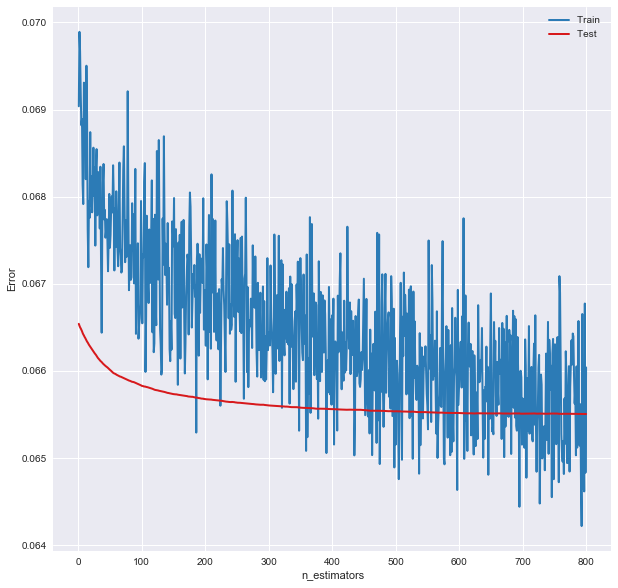

In [9]:
n_estimators = len(best_model.estimators_)

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6',
                  test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label,
             linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    return test_dev, ax

test_dev, ax = deviance_plot(best_model, X_test, y_test)
ax.legend(loc='upper right')

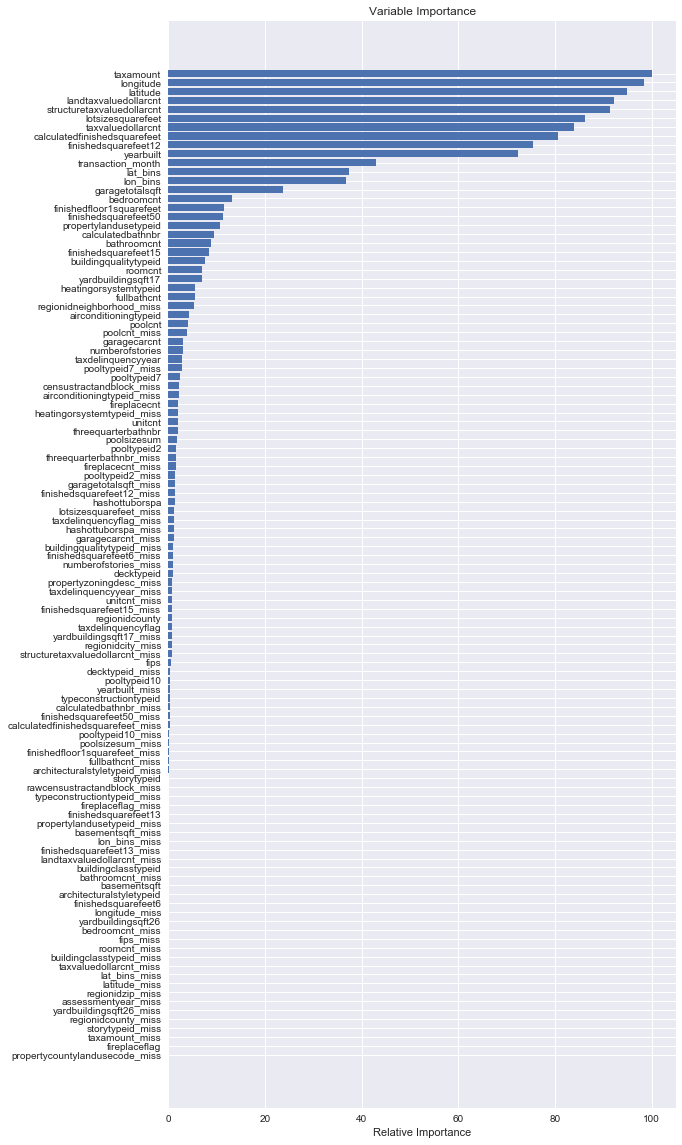

In [10]:
feature_importance = best_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [11]:
parcels = properties.parcelid.unique()
# parcels_df = pd.DataFrame(parcels, columns = ['ParcelId'])

parcels_df = pd.DataFrame({'parcelid': parcels, 'dummy': np.zeros(len(parcels))})

#Create a row for each parcel for each month to be scored
trxn_months = pd.DataFrame({'transactiondate': ['2016/10/01', '2016/11/01', '2016/12/01', '2017/10/01', '2017/11/01', '2017/12/01'],
                            'logerror': np.ones(6),
                            'dummy': np.zeros(6)})

trxn_months.transactiondate = pd.to_datetime(trxn_months.transactiondate)

scoring_drv = pd.merge(parcels_df, trxn_months, how='outer', on='dummy').drop('dummy', axis=1)

In [12]:
'''
Merge the driver with properties
Transform data
Create x dataframe
Feed x into predict method of estimator
'''

# Merge driver with properties
scoring = pd.merge(scoring_drv,properties,how='left',on='parcelid')

#.....................................
# Transform data
scoring['transaction_month'] = scoring['transactiondate'].dt.month

# Bin latitude and longitude to avoid overfit
scoring['lat_bins'] = pd.cut(scoring.latitude, lat_bins, labels=np.arange(100))
scoring['lon_bins'] = pd.cut(scoring.longitude, lon_bins, labels=np.arange(100))

# Create missing indicators
for key in nan_subs:
    scoring[key+'_miss'] = scoring[key].isnull()

# Fill NaN's with imputations
scoring.fillna(nan_subs, inplace=True)

# Convert ordinal characters to ordinal numeric
taxdelinquencyflag_mapping = {'Y': 1, 'N': 0}
scoring.taxdelinquencyflag = scoring.taxdelinquencyflag.map(taxdelinquencyflag_mapping)

#.....................................


x_predict = scoring.drop(drop_cols+drop_indices, axis=1)
submission_y = best_model.predict(x_predict)


In [13]:
# Append y's to driver
submission_nonpivoted = pd.DataFrame({
        "ParcelId": scoring["parcelid"],
        "transactiondate": scoring["transactiondate"],
        "Pred": submission_y
    })

,ParcelId,Pred,transactiondate
0,10754147,0.004958,2016-10-01
1,10754147,0.006142,2016-11-01
2,10754147,0.005907,2016-12-01
3,10754147,0.004958,2017-10-01
4,10754147,0.006142,2017-11-01
5,10754147,0.005907,2017-12-01
6,10759547,-0.009690,2016-10-01
7,10759547,-0.008636,2016-11-01
8,10759547,-0.009107,2016-12-01
9,10759547,-0.009690,2017-10-01


In [14]:
submission = submission_nonpivoted.pivot(index='ParcelId', columns='transactiondate', values='Pred').reset_index()
submission.columns = ['ParcelID', '201610', '201611', '201612', '201710', '201711', '201712']
submission.to_csv('../data/submission.csv', index=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# create model
lamap = merged.copy(deep=True)
lamap.dropna(axis=0, how='any', inplace=True)
X = lamap[['lat_bins', 'lon_bins']]
months = pd.get_dummies(lamap.transaction_month)
x = X.join(months)
y = lamap[['logerror']]
# x.isnull().groupby(['latitude', 'longitude']).count()
X = x.as_matrix()
Y = y.as_matrix()

In [ ]:
model = Sequential()
model.add(Dense(60, input_dim=14, activation='sigmoid'))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=500, batch_size=100)

In [ ]:
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))